# ****Verinin Etiketlenmesi ve DataFrame Oluşturma****

****Bu bölümde, balık veri kümesindeki .png uzantılı görüntüler için etiketler ve dosya yolları toplanarak bir Pandas DataFrame oluşturuyoruz.Daha sonra dataframe'e ön bakış yapıyoruz.****


In [3]:
import numpy as np #for linear algebra
import pandas as pd #for data processing
label = []
path = []
fish_dir ='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':
            if dir_name.split()[-1]!='GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))
                
        
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

In [4]:
data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [5]:
data.tail()

,path,label
8995,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8996,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8997,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8998,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8999,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


# Görüntülerin Yüklenmesi ve Normalizasyonu

****Bu aşamada,bir DataFrame içindeki görüntüler belirtilen boyutlara yükleniyor, normalleştiriliyor ve etiketleri ile birlikte NumPy dizileri olarak döndürülüyor.****

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(df, target_size=(128,128)):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = load_img(row['path'], target_size=target_size)
        img = img_to_array(img)
        img = img / 255.0  # Normalizasyon
        images.append(img)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

# Görüntülerin Yüklenmesi ve Etiketlerin Alınması

In [8]:
X, y = load_images(data)

# Etiketlerin Sayısal Değerlere Dönüştürülmesi ve Veri Setinin Ayırılması

****Bu bölümde, kategorik etiketler sayısal değerlere dönüştürülerek eğitim ve test verileri %80-%20 oranında ayrılıyor; daha sonra, eğitim ve test etiketleri one-hot encoding ile model eğitimi için uygun bir format haline getirildi.****

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
# Kategorik etiketleri sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y, orijinal etiket dizinidir.

# Eğitim ve test verilerini ayırma
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# One-hot encoding
num_classes = len(label_encoder.classes_)  # Sınıf sayısını alıyoruz
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# Boyut kontrolünü sağlıyoruz
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train_encoded.shape)
print('y_train_one_hot shape:', y_train_one_hot.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test_encoded.shape)
print('y_test_one_hot shape:', y_test_one_hot.shape)


X_train shape: (7200, 128, 128, 3)
y_train shape: (7200,)
y_train_one_hot shape: (7200, 9)
X_test shape: (1800, 128, 128, 3)
y_test shape: (1800,)
y_test_one_hot shape: (1800, 9)


# Görüntülerin Görselleştirilmesi

****Matplotlib kullanılarak örnek görüntüler gösteriliyor, böylece veri setinin içeriği görsel olarak inceliyoruz.****

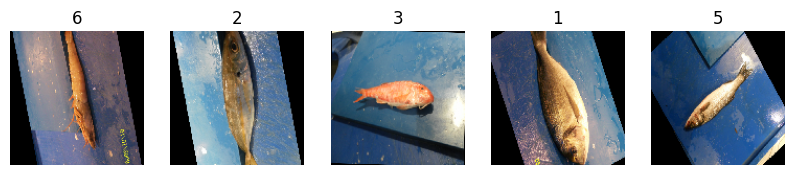

In [10]:
import matplotlib.pyplot as plt

def plot_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'{labels[i]}')
        plt.axis('off')
    plt.show()
    
plot_images(X_train, y_train_encoded, num_images=5)    

# Modelin Oluşturulması ve Derlenmesi

****Hidden layerlarda ilk olarak dropout ile denendi fakat bu şekilde daha iyi sonuç alındı.****

In [11]:
# Modeli yükleme
model = tf.keras.models.Sequential()

# Input nesnesi (input boyutu 49152)
model.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(49152,)))
#Input düzleştirme işlemi
model.add(tf.keras.layers.Flatten())

# Input katmanı
model.add(tf.keras.layers.Dense(512, activation='relu'))

# Hidden Layer 1
model.add(tf.keras.layers.Dense(512, activation='relu')) 

# Hidden Layer 2
model.add(tf.keras.layers.Dense(256, activation='relu')) 

# Hidden Layer 3
model.add(tf.keras.layers.Dense(128, activation='relu')) 


# Output layer
model.add(tf.keras.layers.Dense(9, activation='softmax'))

# Modelin derlenmesi
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,857,033 (98.64 MB)

 Trainable params: 25,857,033 (98.64 MB)

 Non-trainable params: 0 (0.00 B)

# Modelin Eğitimi

****Eğitim aşamasında,eğitim süreci başlatıldı; doğrulama kaybını izleyerek erken durma için EarlyStopping callback tanımlandı, eğitim ve test verileri düzleştirildi ve model, 100 epoch boyunca 64 örnek mini-batch ile eğitildi.****

In [12]:
from keras.callbacks import EarlyStopping

# EarlyStopping tanımı
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# X_train ve X_test'i düzleştirme
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Model eğitimi
results = model.fit(
    X_train_flattened,
    y_train_one_hot,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_flattened, y_test_one_hot),
    callbacks=[early_stopping]  
)


Epoch 1/100


I0000 00:00:1729796030.512079     104 service.cc:145] XLA service 0x7abc40005e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729796030.512162     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729796030.512169     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 16/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0695 - loss: 9.9984

I0000 00:00:1729796033.056250     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.1550 - loss: 5.2857 - val_accuracy: 0.4144 - val_loss: 1.4939
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4918 - loss: 1.3649 - val_accuracy: 0.5033 - val_loss: 1.3242
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6697 - loss: 0.9350 - val_accuracy: 0.7450 - val_loss: 0.7061
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7631 - loss: 0.6863 - val_accuracy: 0.8117 - val_loss: 0.5368
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8445 - loss: 0.4506 - val_accuracy: 0.8556 - val_loss: 0.4051
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8766 - loss: 0.3584 - val_accuracy: 0.8983 - val_loss: 0.3007
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9111 - loss: 0.2605 - val_accuracy: 0.8706 - val_loss: 0.3917
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9214 - loss: 0.2146 - val_accuracy

# Eğitim Sonuçlarının Görselleştirilmesi

****Modelin performansını epochlar boyunca takip ediyoruz.****

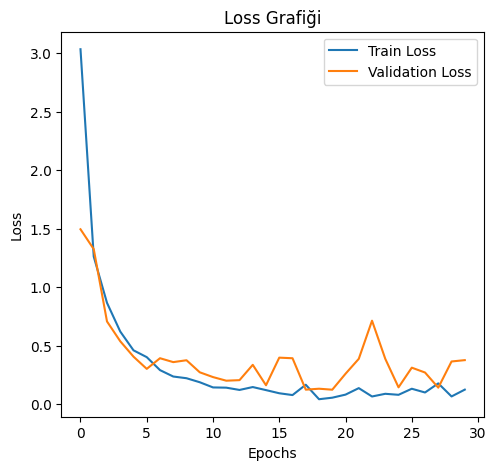

In [13]:
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

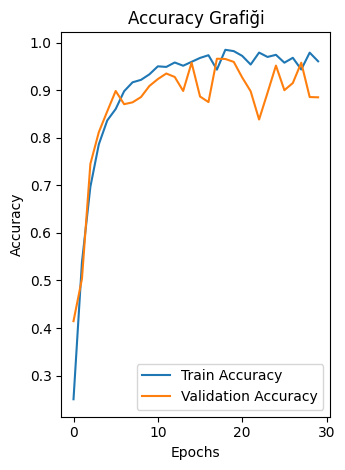

In [14]:
# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Test Verisi ile Tahmin İşlemi

****Outputta görüldüğü üzere testin doğruluğu %95.94. Model başarılı bir şekilde eğitildi.****

In [15]:
# Test verisi ile tahmin işlemi
y_pred = model.predict(X_test_flattened)

# Tahmin edilen etiketleri al (en yüksek olasılığa sahip olan sınıfı seç)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketler
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Modelin başarı oranını hesaplama
accuracy = np.mean(y_pred_classes == y_true_classes)
print(f'Test Doğruluğu: {accuracy * 100:.2f}%')

# Sonuçları ekrana yazdırma (örnek olarak ilk 15 tahmini için bakalım)
print("Gerçek Etiketler: ", y_true_classes[:15])
print("Tahmin Edilen Etiketler: ", y_pred_classes[:15])


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test Doğruluğu: 95.94%
Gerçek Etiketler:  [1 0 2 8 4 4 7 4 3 8 3 7 3 6 1]
Tahmin Edilen Etiketler:  [1 6 2 8 4 4 7 4 3 4 3 7 3 6 1]


# Confusion Matrix Görselleştirilmesi

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


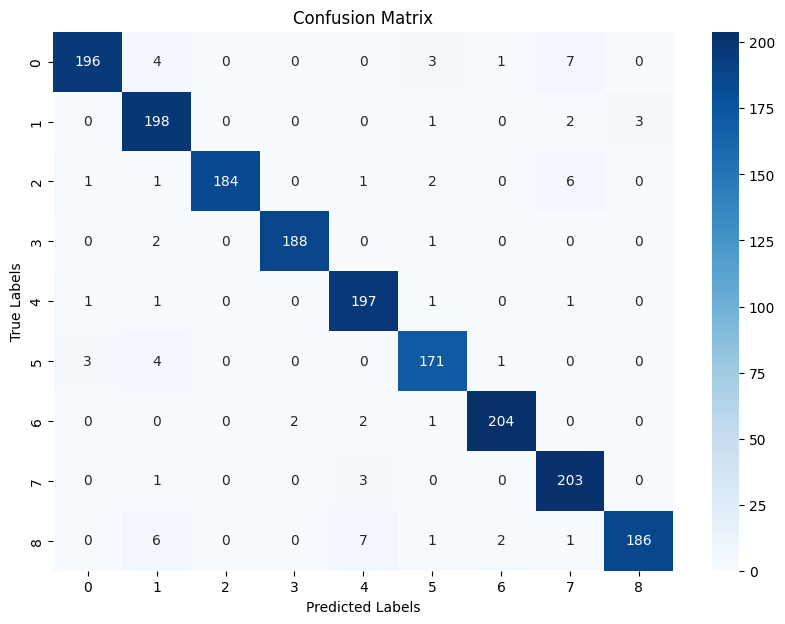

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Test verisi kullanılarak predict
y_pred = model.predict(X_test_flattened)

# Tahmin edilen etiketleri al (en yüksek olasılığa sahip olan sınıfı seç)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketler
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Confusion matrix'i oluşturma
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Confusion matrix'i ekrana getirme 
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
